In [1]:
import sys
import matplotlib.pyplot as plt
import vaex
import os
import numpy as np
import pandas as pd
from helpers import *
import matplotlib.pyplot as plt


In [3]:
current_dir  = os.getcwd()
#We assume that the data for the specific ticker is already cleaned, here is a list of cleaned tickers
ticker_list = os.listdir(os.path.join(current_dir,"data","clean",
                            "flash_crash"))
ticker_name = ticker_list[1]
loading_dir = os.path.join(current_dir,"data","clean",
                            "flash_crash")

plots_dir = os.path.join(current_dir,"plots","flash_crash",
                        ticker_name)
file_dir = os.path.join(loading_dir,ticker_name)
file_name = os.listdir(file_dir)[0]
df=vaex.open(os.path.join(file_dir,file_name))
df.head()

#,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume,index
0,nan,nan,213.32,1,213.42,1,2010-01-04 14:30:00.000999936
1,nan,nan,213.37,1,213.5,3,2010-01-04 14:30:00.009000192
2,nan,nan,213.38,2,213.5,1,2010-01-04 14:30:00.020000
3,nan,nan,213.39,1,213.5,1,2010-01-04 14:30:00.042000128
4,nan,nan,213.4,1,213.5,1,2010-01-04 14:30:00.087999744
5,nan,nan,213.42,2,213.5,1,2010-01-04 14:30:00.095999744
6,nan,nan,213.42,1,213.5,1,2010-01-04 14:30:00.129999872
7,nan,nan,213.38,1,213.5,1,2010-01-04 14:30:00.140999936
8,nan,nan,213.41,2,213.5,1,2010-01-04 14:30:00.141999616
9,nan,nan,213.39,1,213.5,1,2010-01-04 14:30:00.148000


### 1) Inspecting Crash day

In [4]:
#Filter the day of the crash
crash_start_date = '2010-05-06'
crash_end_date = '2010-05-07'

filtered_df = df.copy()
filtered_df = filtered_df[(filtered_df['index'] >= crash_start_date) & (filtered_df['index'] <= crash_end_date)]

ny_index = pd.DatetimeIndex(filtered_df['index'].values) 
ny_index = ny_index.tz_localize('UTC').tz_convert('America/New_York')

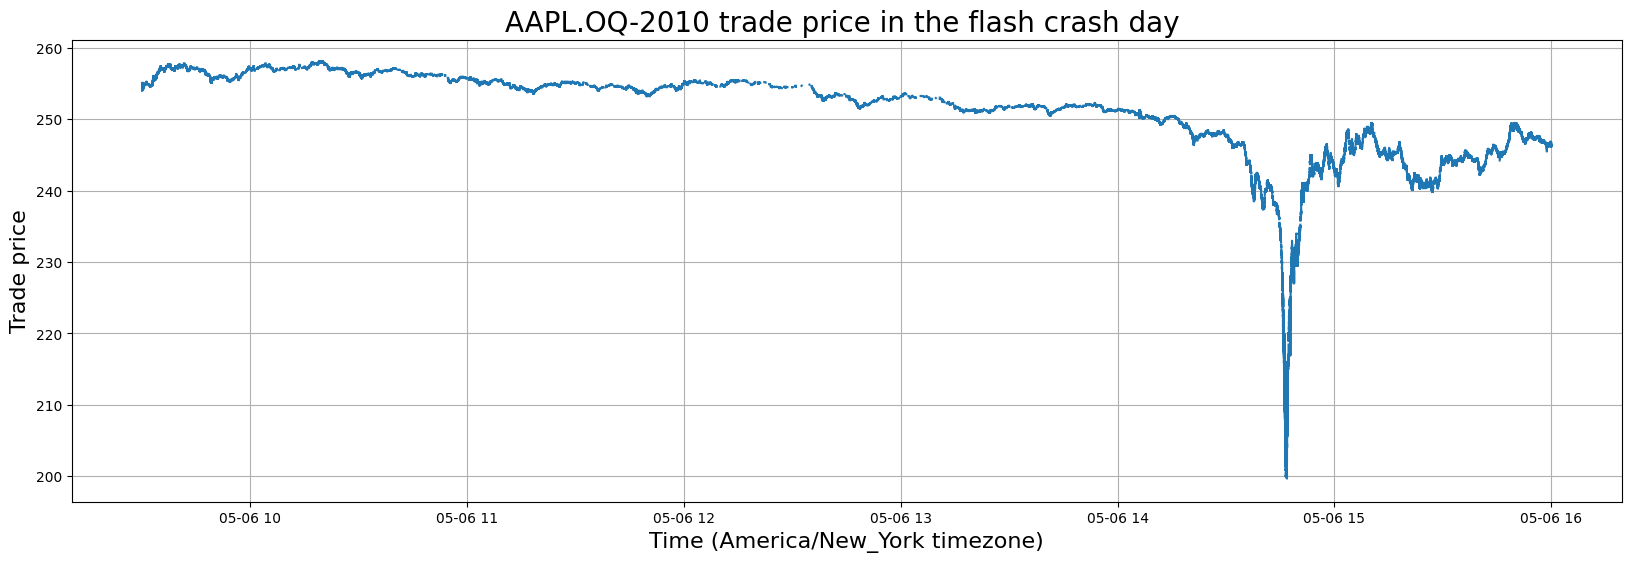

In [5]:
#Trade Price
plotYvsX(ny_index , filtered_df['trade_price'].values,
                'Time (America/New_York timezone)','Trade price',
                f'{ticker_name} trade price in the flash crash day ',plots_dir)

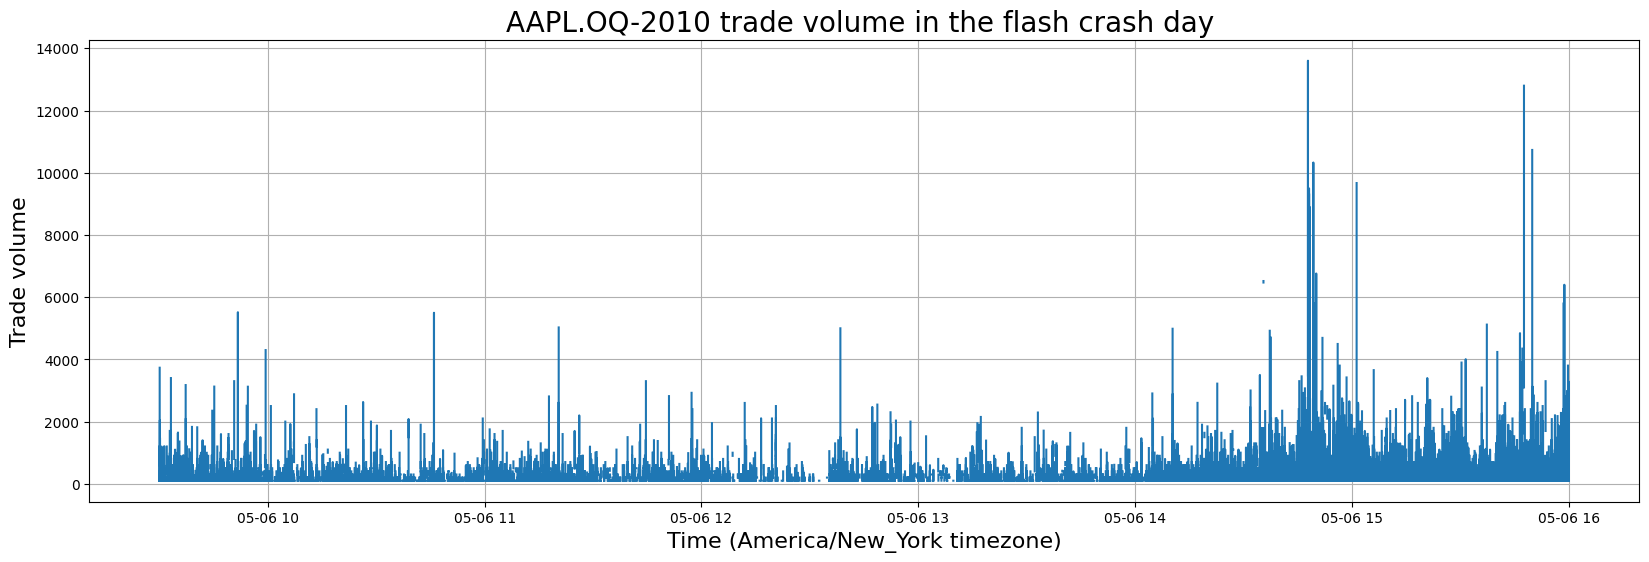

In [6]:
#Trade volume
plotYvsX(ny_index, filtered_df['trade_volume'].values,
                'Time (America/New_York timezone)','Trade volume',
                f'{ticker_name} trade volume in the flash crash day ',plots_dir)

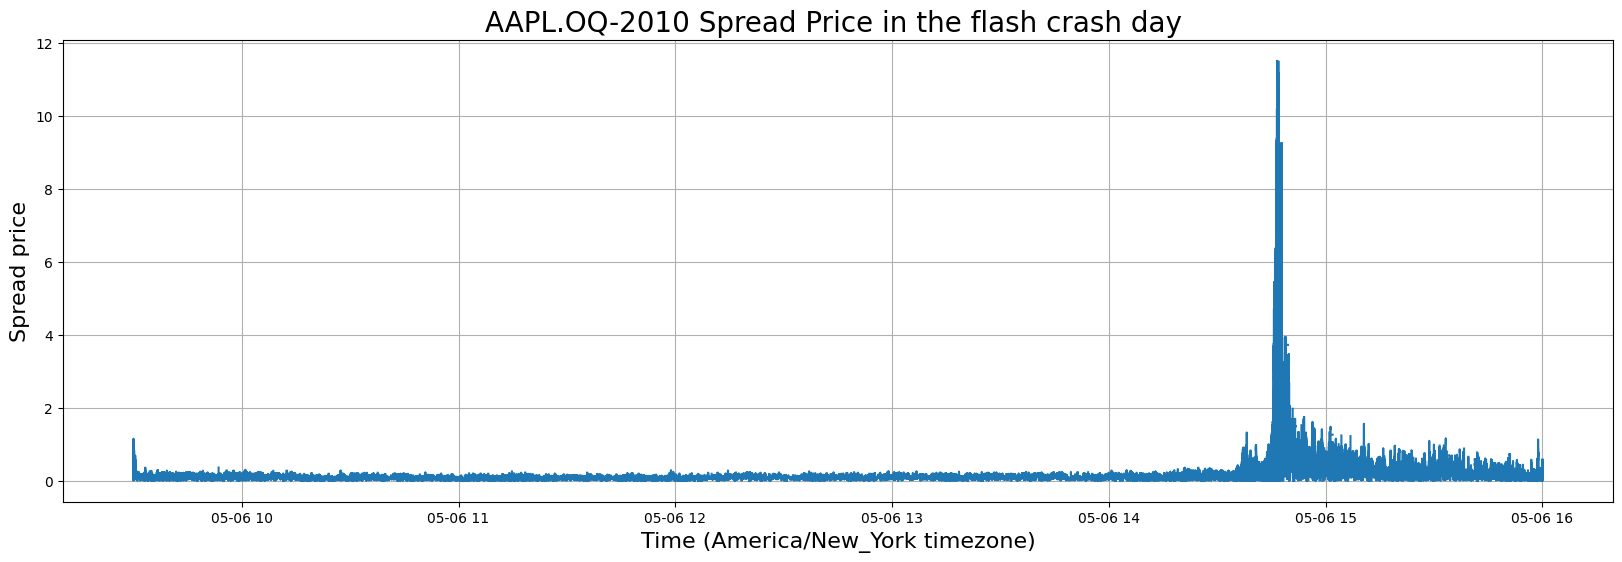

In [7]:
#### Spread
plotYvsX(ny_index,
                np.array(filtered_df['ask-price'].values)- np.array(filtered_df['bid-price'].values),
                'Time (America/New_York timezone)','Spread price',
                f'{ticker_name} Spread Price in the flash crash day ',plots_dir)

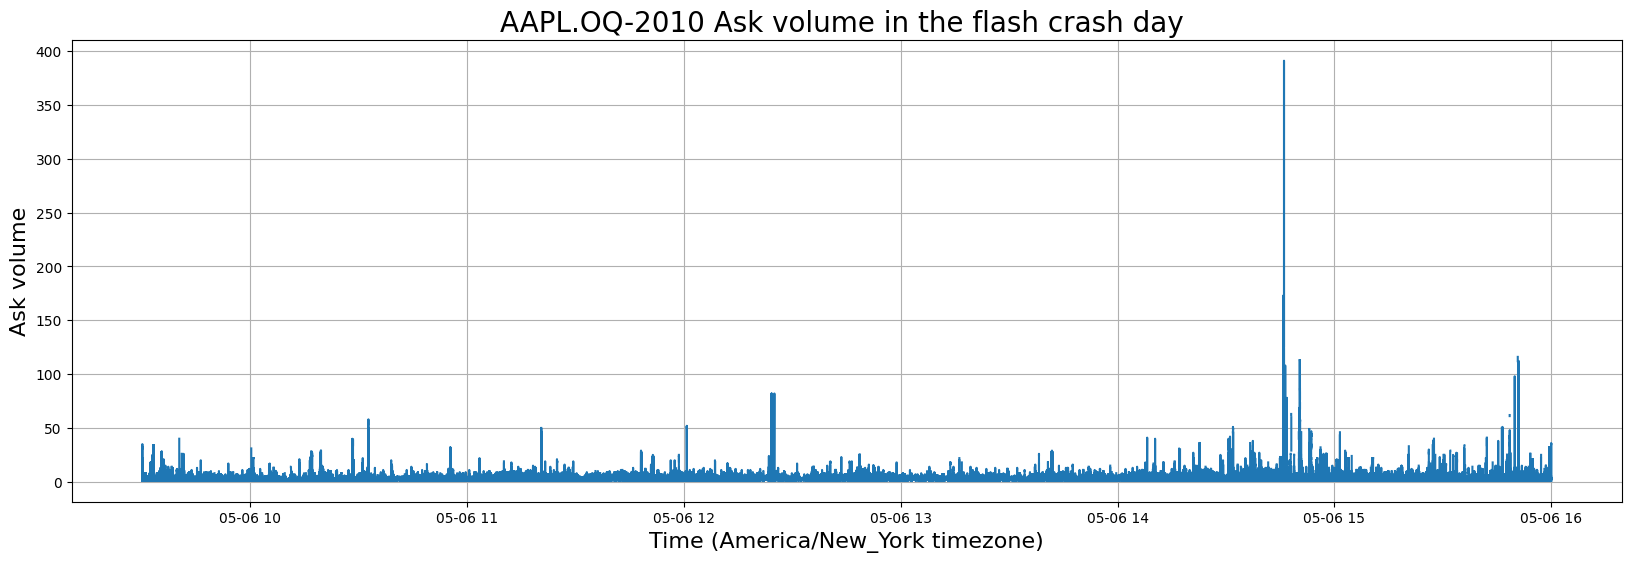

In [8]:
#Ask volume
plotYvsX(ny_index, filtered_df['ask-volume'].values,
                'Time (America/New_York timezone)','Ask volume',
                f'{ticker_name} Ask volume in the flash crash day ',plots_dir)

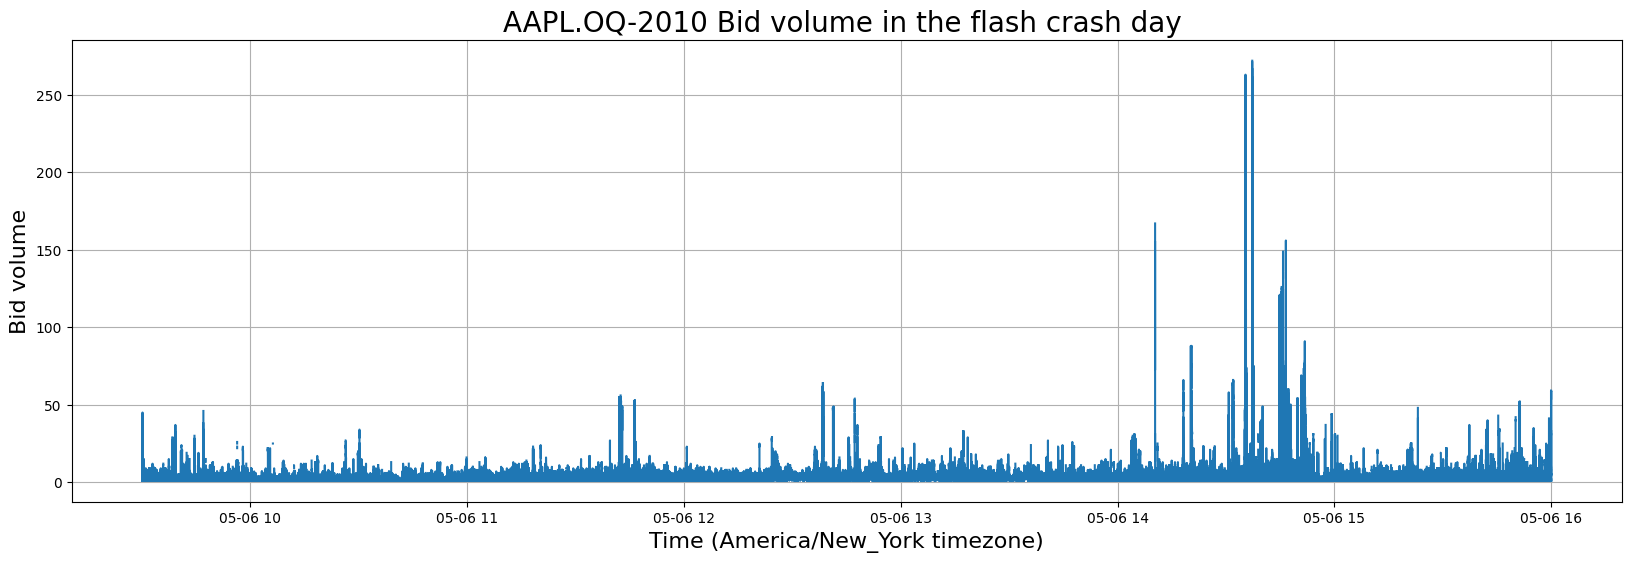

In [9]:
### Bid volume 
plotYvsX(ny_index, filtered_df['bid-volume'].values,
                'Time (America/New_York timezone)','Bid volume',
                f'{ticker_name} Bid volume in the flash crash day ',plots_dir)

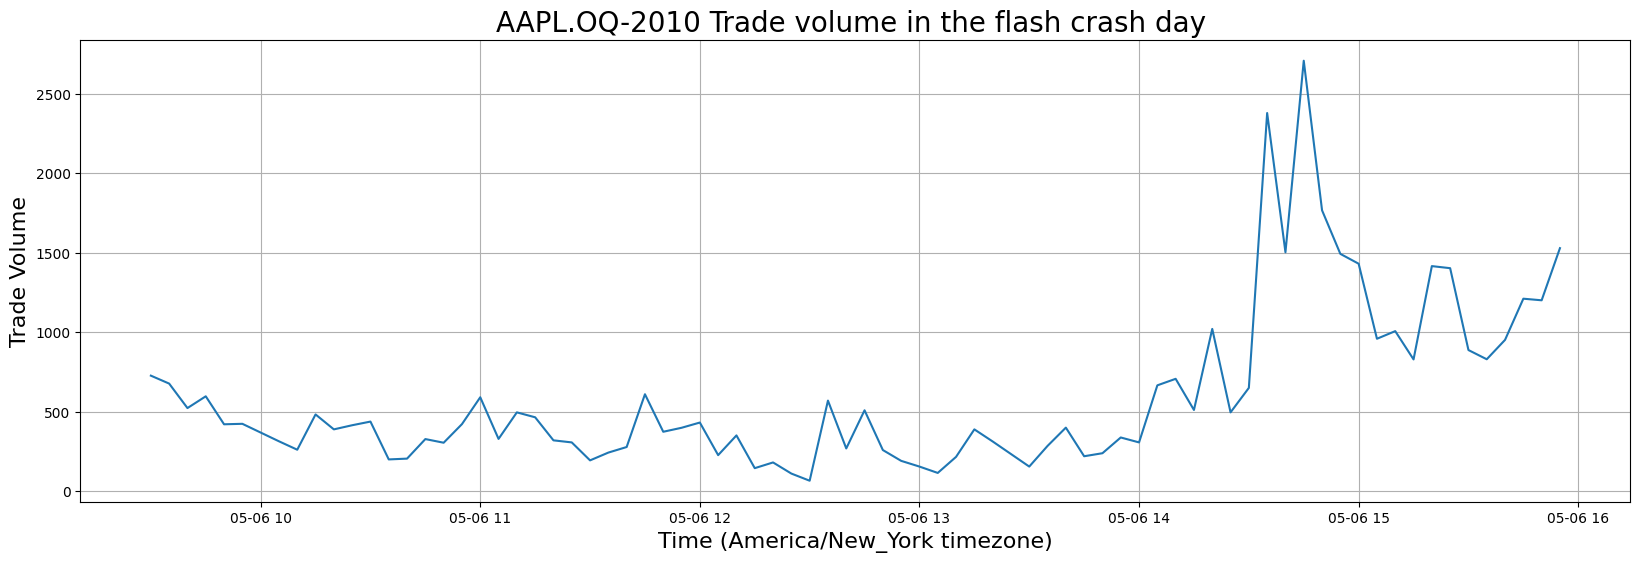

In [10]:
# Number of trades  per 5 min during the day of the Crash 
df_crash = filtered_df.copy()
df_crash = df_crash.to_pandas_df()
df_crash['ny_index'] = ny_index 
df_crash.set_index('ny_index',drop=True,inplace=True)
trade_counts = df_crash['trade_volume'].notna().resample('5T').sum()
plotYvsX(trade_counts.index, trade_counts , 'Time (America/New_York timezone)','Trade Volume',
                f'{ticker_name} Trade volume in the flash crash day ',plots_dir)


#### 2) Trade classification: Using Lee-Ready algo

In [11]:
# Fill the missing values in the bid and ask price 
df_crash.loc[:, ['bid-price','ask-price']] = df_crash[['bid-price','ask-price']].ffill()
# Compute the mid price
df_crash['mid_price'] = (df_crash['ask-price'] + df_crash['bid-price']) / 2
df_crash['prev_mid_price']  = df_crash['mid_price'].shift(1)
df_crash['prev_trade']= df_crash['trade_price'].shift(1)
df_crash['trade_class'] = np.nan
# Apply the function to each row
df_crash['trade_class'] = df_crash.apply(classify_trade, axis=1)
df_crash

,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume,index,mid_price,prev_mid_price,prev_trade,trade_class
ny_index,,,,,,,,,,,
2010-05-06 09:30:00.047999488-04:00,NaN,NaN,253.53,6.0,254.17,8.0,2010-05-06 13:30:00.047999488,253.850,NaN,NaN,NaN
2010-05-06 09:30:00.101999872-04:00,NaN,NaN,253.53,6.0,254.15,5.0,2010-05-06 13:30:00.101999872,253.840,253.850,NaN,NaN
2010-05-06 09:30:00.134000128-04:00,NaN,NaN,253.53,6.0,253.89,1.0,2010-05-06 13:30:00.134000128,253.710,253.840,NaN,NaN
2010-05-06 09:30:00.140000-04:00,NaN,NaN,253.53,7.0,253.89,1.0,2010-05-06 13:30:00.140000000,253.710,253.710,NaN,NaN
2010-05-06 09:30:00.226000128-04:00,NaN,NaN,253.53,7.0,254.15,5.0,2010-05-06 13:30:00.226000128,253.840,253.710,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2010-05-06 15:59:59.721999872-04:00,246.140,845.0,246.12,2.0,246.70,35.0,2010-05-06 19:59:59.721999872,246.410,246.135,NaN,1.0
2010-05-06 15:59:59.731999744-04:00,246.135,3055.0,246.12,NaN,246.70,NaN,2010-05-06 19:59:59.731999744,246.410,246.410,246.140,-1.0
2010-05-06 15:59:59.809999872-04:00,246.620,100.0,246.12,NaN,246.70,NaN,2010-05-06 19:59:59.809999872,246.410,246.410,246.135,1.0


In [12]:
df_crash.groupby('trade_class').count()

,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume,index,mid_price,prev_mid_price,prev_trade
trade_class,,,,,,,,,,
-1.0,24406,24406,24406,10856,24406,10856,24406,24406,24406,8357
1.0,21854,21854,21854,9788,21854,9788,21854,21854,21854,7639


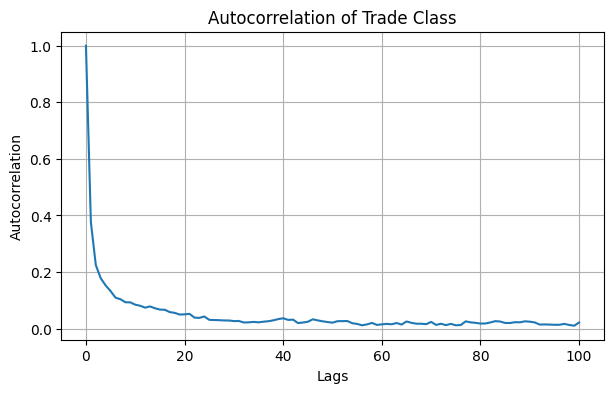

In [13]:
# Assuming 'trade_class' is the column for autocorrelation analysis
# First, let's clean the data by dropping NaN values as autocorrelation
# requires non-null values
df_clean = df_crash.dropna(subset=['trade_class'])

# Check if there's enough data for autocorrelation analysis
if len(df_clean) < 2:
    print("Not enough data for autocorrelation analysis.")
else:
    # Calculate and plot autocorrelation for 'trade_class'
    acf_result = sm.tsa.acf(df_clean['trade_class'], nlags=100, fft=True)

    plt.figure(figsize=(7, 4))
    plt.plot(acf_result)
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation of Trade Class')
    plt.grid(True)
    plt.show()


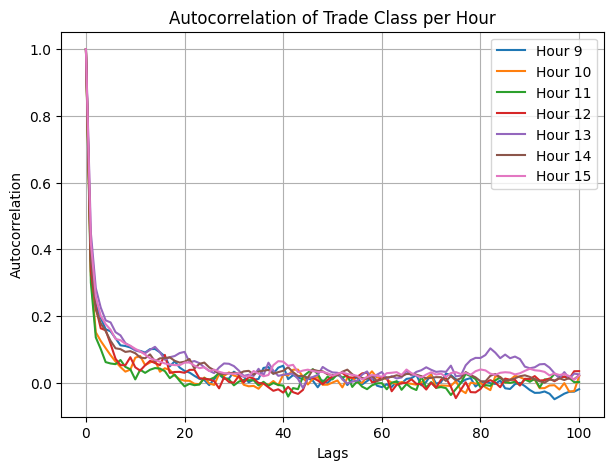

In [14]:
df_crash['hour'] = df_crash.index.hour
plt.figure(figsize=(7, 5))

# Group the DataFrame by hour and compute autocorrelation for each group
for hour in df_crash['hour'].unique():
    df_hour = df_crash[df_crash['hour'] == hour]
    df_hour_clean = df_hour.dropna(subset=['trade_class'])
    
    if len(df_hour_clean) > 10:  # Check if there's enough data for autocorrelation analysis
        acf_result = sm.tsa.acf(df_hour_clean['trade_class'], nlags=100, fft=True)
        # Plot the autocorrelation
        plt.plot(acf_result, label=f'Hour {hour}')
    else:
        print(f"Not enough data for autocorrelation analysis for hour {hour}.")
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title(f'Autocorrelation of Trade Class per Hour')
plt.legend()
plt.grid()
plt.show()

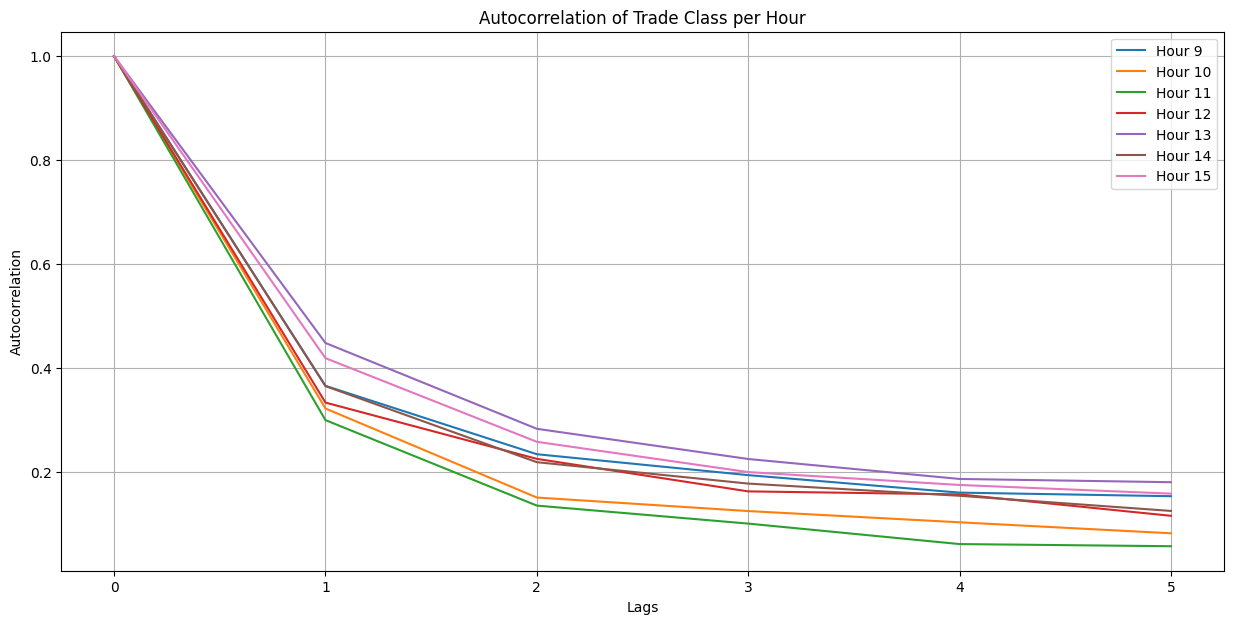

In [15]:
df_crash['hour'] = df_crash.index.hour
plt.figure(figsize=(15, 7))

# Group the DataFrame by hour and compute autocorrelation for each group
for hour in df_crash['hour'].unique():
    df_hour = df_crash[df_crash['hour'] == hour]
    df_hour_clean = df_hour.dropna(subset=['trade_class'])
    
    if len(df_hour_clean) > 10:  # Check if there's enough data for autocorrelation analysis
        acf_result = sm.tsa.acf(df_hour_clean['trade_class'], nlags=5, fft=True)
        # Plot the autocorrelation
        plt.plot(acf_result, label=f'Hour {hour}')
    else:
        print(f"Not enough data for autocorrelation analysis for hour {hour}.")
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title(f'Autocorrelation of Trade Class per Hour')
plt.legend()
plt.grid()
plt.show()

#### Discussion : 
We can see that the trades in middle of the day are still predictable after 1 or 2 lags.